<a href="https://colab.research.google.com/github/dkaikas/AI-in-Cybersecurity/blob/main/Darknet_Traffic_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Darknet Traffic Classification using Machine Learning
Ανίχνευση και ταξινόμηση της κυκλοφορίας Tor από μη-Tor σε δίκτυα υπολογιστών.
Αξιοποιούμε τεχνικές μηχανικής μάθησης για να υλοποιήσουμε ένα σύστημα εντοπισμού πιθανής κακόβουλης κυκλοφορίας.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical


## Φόρτωση και Προεπισκόπηση Δεδομένων

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv')
df.head()


<ipython-input-14-051ca000cfed>:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv')


,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label-1,Label-2
0,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
1,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
2,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
3,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
4,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1437760000000000,3117718.131,1437760000000000,1437760000000000,Non-Tor,AUDIO-STREAMING


## Καθαρισμός και Προεπεξεργασία Δεδομένων

In [ ]:
# Αφαίρεση IPs και Label-2
df = df.drop(columns=["Src_IP", "Dst_IP", "Label-2"])

# Αντικατάσταση '∞' με NaN και μετατροπή σε float
df["Flow_Bytes/s"] = pd.to_numeric(df["Flow_Bytes/s"], errors='coerce')

# Αντικατάσταση NaN με 0 (ή θα μπορούσαμε να χρησιμοποιήσουμε μέσο όρο/median)
df = df.fillna(0)

# Μετατροπή Label σε αριθμητική τιμή: Tor = 1, Non-Tor = 0
df["Label"] = df["Label-1"].apply(lambda x: 1 if x.strip() == "Tor" else 0)
df = df.drop(columns=["Label-1"])


##  Εξερεύνηση Δεδομένων

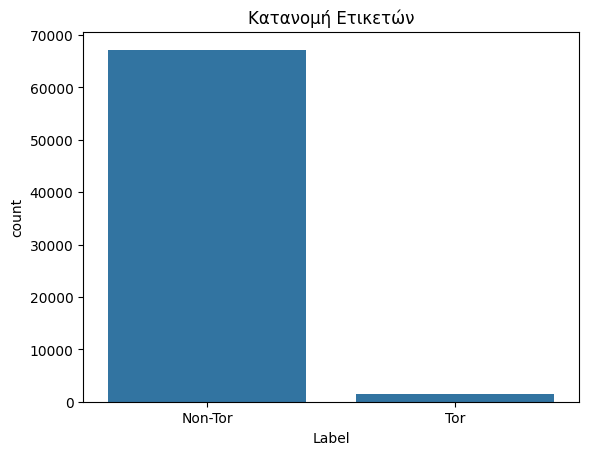

In [ ]:
sns.countplot(data=df, x="Label")
plt.xticks([0, 1], ["Non-Tor", "Tor"])
plt.title("Κατανομή Ετικετών")
plt.show()


## Επιλογή Χαρακτηριστικών και Διαχωρισμός Συνόλων

In [ ]:
# Αντικατάσταση όλων των inf με NaN και έπειτα με 0
X = df.drop(columns=["Label"])
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Κανονικοποίηση
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Διαχωρισμός
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred_rf = rfc.predict(X_test)

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13438
           1       0.98      0.91      0.94       278

    accuracy                           1.00     13716
   macro avg       0.99      0.96      0.97     13716
weighted avg       1.00      1.00      1.00     13716

ROC-AUC: 0.9566112848670313


## XGBoost Classifier

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:24:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13438
           1       0.99      0.94      0.96       278

    accuracy                           1.00     13716
   macro avg       1.00      0.97      0.98     13716
weighted avg       1.00      1.00      1.00     13716

ROC-AUC: 0.9693500445959649


## Νευρωνικό Δίκτυο

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.1)

y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report (Neural Net):")
print(classification_report(y_test, y_pred_nn))


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9254 - loss: 0.2224 - val_accuracy: 0.9929 - val_loss: 0.0307
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9933 - loss: 0.0295 - val_accuracy: 0.9933 - val_loss: 0.0281
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9936 - loss: 0.0263 - val_accuracy: 0.9944 - val_loss: 0.0245
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9943 - loss: 0.0224 - val_accuracy: 0.9944 - val_loss: 0.0225
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.0226 - val_accuracy: 0.9944 - val_loss: 0.0218
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9954 - loss: 0.0187 - val_accuracy: 0.9947 - val_loss: 0.0200
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9951 - loss: 0.0189 - val_accuracy: 0.9951 - val_loss: 0.0201
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9957 - loss: 0.0189 - val_accuracy: 0.

## Προσομοίωση IPS Απόκρισης

In [ ]:
def ips_response(predicted_label, source_ip="192.168.1.100"):
    if predicted_label == 1:
        print(f"🚨 Tor traffic detected from {source_ip} — blocking and alerting admin.")
    else:
        print(f"✅ Normal traffic from {source_ip} — no action required.")

# Παράδειγμα χρήσης:
ips_response(y_pred_rf[0])


✅ Normal traffic from 192.168.1.100 — no action required.
